<a href="https://colab.research.google.com/github/ritwikraha/computer-needs-glasses/blob/master/image-generation/Comics_Style_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 15.7 MB/s eta 0:00:00


In [3]:
import requests
import io
import torch
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlopen
from diffusers import LCMScheduler, AutoPipelineForText2Image, DiffusionPipeline, AutoencoderKL
from diffusers import StableDiffusionImg2ImgPipeline, AutoPipelineForImage2Image

In [4]:
def resize_image_from_url_with_aspect_ratio(url, base_width=1024, base_height=None):
    try:
        with urlopen(url) as response:
            raw_data = response.read()
        img = Image.open(io.BytesIO(raw_data)).convert("RGB")

        # Get the current width and height of the image
        width, height = img.size

        # Calculate the new dimensions based on the aspect ratio
        if base_width is not None:
            # Calculate new height based on the base_width to maintain aspect ratio
            w_percent = (base_width / float(width))
            h_size = int((float(height) * float(w_percent)))
            new_size = (base_width, h_size)
        elif base_height is not None:
            # Calculate new width based on the base_height to maintain aspect ratio
            h_percent = (base_height / float(height))
            w_size = int((float(width) * float(h_percent)))
            new_size = (w_size, base_height)
        else:
            raise ValueError("Either base_width or base_height must be provided")

        # Resize the image
        resized_img = img.resize(new_size, Image.ANTIALIAS)
        return resized_img
    except Exception as e:
        print(f"Error loading or resizing image from URL: {e}")
        return None

<ipython-input-4-a8d817d202be>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(new_size, Image.ANTIALIAS)


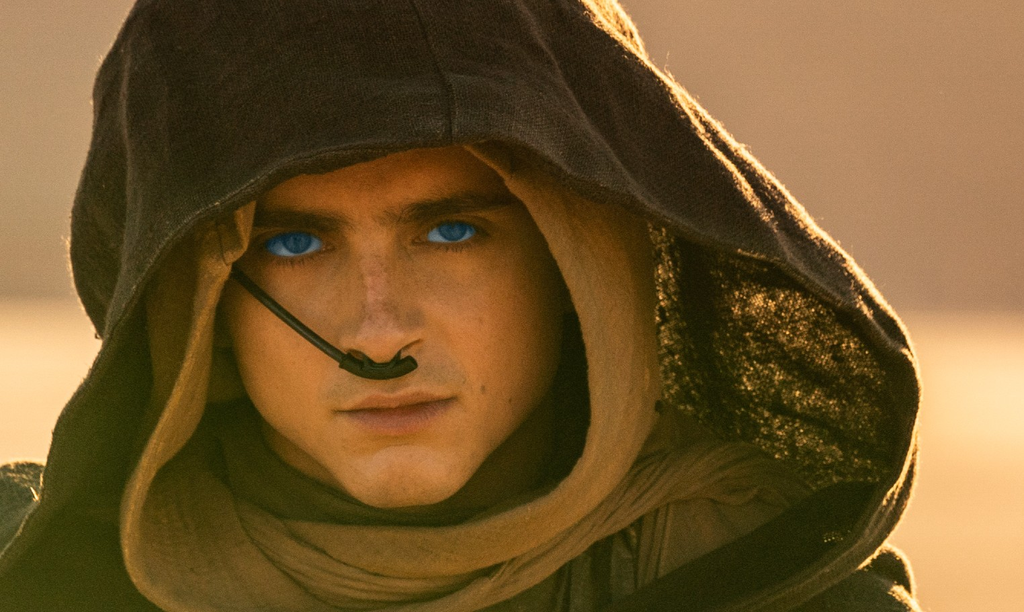

In [5]:
url = "https://www.denofgeek.com/wp-content/uploads/2023/05/dune-2-paul-atreides-timothee-chalamet.jpg"
init_image = resize_image_from_url_with_aspect_ratio(url)
init_image

In [6]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True)


pipeline.load_lora_weights('ritwikraha/comics_style_LoRA')
_ = pipeline.to("cuda")

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/25 [00:00<?, ?it/s]

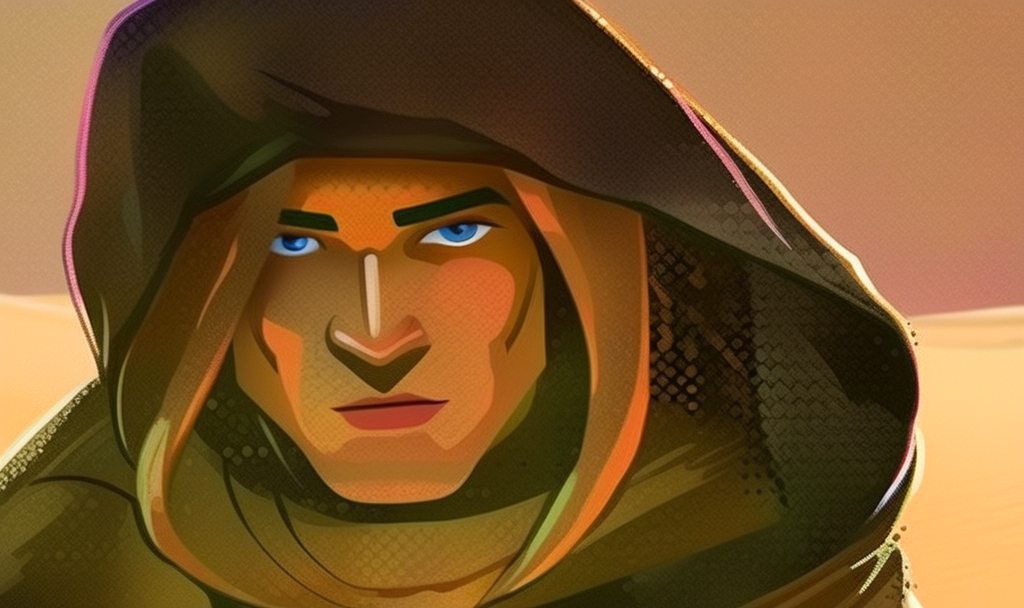

In [15]:
prompt = "illustration of a man in desert with blue eyes, in the style of TOK comics, 8k"
negative_prompt ="ugly face, multiple bodies, bad anatomy, disfigured, extra fingers"
output = pipeline(prompt=prompt,
              negative_prompt=negative_prompt,
              image=init_image,
              strength=0.5,
              scheduler=LCMScheduler.from_config(pipeline.scheduler.config),
              guidance_scale=9.5,
              num_inference_steps=50,
            ).images[0]
output